# Modeling

In this notebook various classification models will be tested in their pridictive power for the errors. As measures precision (few false alarms) and high recall (no error is missed) are taken.

The first models are a **logistic regression** and a **naive Bayes** model. Next, we will go into some more complex classification models like **(kernel) SVM**, **decision tree** or **ensemble based** models. 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import time
%matplotlib inline

In [3]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, f1_score

In [4]:
import matplotlib as mpl
font = {'size':16}
mpl.rc('font',**font)
mpl.rcParams['xtick.labelsize']=14
mpl.rcParams['ytick.labelsize']=14
mpl.rcParams['axes.labelsize']='small'

### Load Functions

In [5]:
def update_results(dic,method,file='../data/results.db'):
    con = sqlite3.connect(file)
    cursor = con.cursor()
    cursor.execute("SELECT * FROM results;")
    if method not in [i[0] for i in cursor.description]:
        cursor.execute("ALTER TABLE results ADD COLUMN '%s' REAL" %method)
        con.commit()
    query = "UPDATE results SET {} = ? WHERE score = ?".format(method)
    for score in dic.keys():
        cursor.execute(query ,(dic[score], score))
        con.commit()
    con.close()
    return;

def score_func(ypredict,ytest,prob=[],prt_info = False):
    # Function returns a dictionary with the key measures, printing the results is optional with prt_info
    accuracy = accuracy_score(ytest,ypredict)
    recall = recall_score(ytest,ypredict)
    precision = precision_score(ytest,ypredict)
    f1sc = f1_score(ytest,ypredict)
    result_dic = {'accuracy':accuracy,'recall':recall,'precision':precision,'f1-score':f1sc}
    if prt_info:
        print('The accuracy is {:.3f}, meaning that {:.1f}% of the data was predicted right.'.format(accuracy, accuracy*100))
        print('The recall is {:.3f}, meaning that {:.1f}% of errors were predicted right.'.format(recall, recall*100))
        print('The precision is {:.3f}, meaning that only {:.1f}% of the predicted errors were actual errors.'.format(precision, precision*100))
        print('The f1 score is {:.3f}.'.format(f1sc))
    if prob:
        prob_y_2 = [p[1] for p in prob]
        roc_auc =roc_auc_score(ytest,prob_y_2)
        result_dic.update({'AUROC':roc_auc})
        if prt_info:
            print('The area under the ROC-AUC curve is {:.3f} with a minimum of 0.5.'.format(roc_auc))
    
    return result_dic;
def feature_def2(feat,file='../data/feature_tabs2.db'):
    table = 'xx'
    for name in ['id','flg','cl','ty','dt']:
        if name in feat:
            table = name
            break
    df = pd.read_sql('SELECT * FROM '+table,'sqlite:///'+file,index_col='index') 
    if feat in df.original.values:
        return df.loc[df.original== feat,'acronym'].iloc[0]
    elif feat in df.acronym.values:
        return df.loc[df.acronym== feat,'original'].iloc[0]
    else:
        print('Feature not found.')
        return []

### Load Data

In [59]:
from scipy.sparse import csr_matrix, save_npz, load_npz
Xtrain = load_npz('../data/data_base_Xtrain2.npz')
Xtest = load_npz('../data/data_base_Xtest2.npz')
df_ytrain = pd.read_sql("SELECT * FROM y_train", 'sqlite:///../data/model_data_base2.db',index_col='index')
df_ytest = pd.read_sql("SELECT * FROM y_test", 'sqlite:///../data/model_data_base2.db',index_col='index')
ytrain = df_ytrain.values.ravel() #.reshape(1,1)
ytest = df_ytest.values.ravel() #.reshape(1,-1)
columns = np.load('../data/data_base_columns2.npy',allow_pickle=True)

In [43]:
print(' {} columns and {} entries'.format(len(columns),len(ytrain)+len(ytest)))

 7737 columns and 38432 entries


Since some model fitting takes a long time and we do not want to repeat this step every time we start the kernel anew, the previous model results are stored in *results_base.db*.

In [50]:
results_file = '../data/results_base2.db'
import os
if os.path.exists(results_file):
    results = pd.read_sql('SELECT * FROM results','sqlite:///'+results_file,index_col='score')
    results.drop('index',axis=1,inplace=True)
    result_dic = results.to_dict()
    print('Existing Scores: ',result_dic.keys())
else:
    results = pd.DataFrame(['accuracy','f1-score','precision','recall'], columns=['score'])
    con = sqlite3.connect(results_file)
    results.to_sql(name='results',con=con,if_exists='replace')
    result_dic = {}
    print('new')
    con.close()

Existing Scores:  dict_keys(['ComplementNB', 'LogisticRegression', 'GridSearch_LogReg', 'RandomSearch_LogReg', 'SVC', 'RandomForest'])


## Naive Bayes
With our data set we can assume that a) errors are instantaneous occurances and do not depend on previous actions, and b) errors do not depend on other jobs occuring at the same time. Therefore, **Naive Bayes** is a good start for our model study.

In [7]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(Xtrain.todense(),ytrain) # does not work with sparse matrixes
ypredict = gnb.predict(Xtest.todense())
method = 'GaussianNB'
result_dic.update({method:score_func(ypredict,ytest,prt_info=True)})
update_results(result_dic[method],method,results_file)

The accuracy is 0.955, meaning that 95.5% of the data was predicted right.
The recall is 0.995, meaning that 99.5% of errors were predicted right.
The precision is 0.521, meaning that only 52.1% of the predicted errors were actual errors.
The f1 score is 0.684.


While the **recall is very good** the **precision is lousy** which is to expected with an imbalanced data set like ours. Before we go into more detailed parameter tuning or reassessment of our data, let's try the **Complement Naive Bayes** model, which is specifically designed for sparse data sets.

In [7]:
from sklearn.naive_bayes import ComplementNB
cnb = ComplementNB()
cnb.fit(Xtrain,ytrain)
ypredict = cnb.predict(Xtest)
method = 'ComplementNB'
result_dic.update({method:score_func(ypredict,ytest,prt_info=True)})
update_results(result_dic[method],method,results_file)

The accuracy is 0.888, meaning that 88.8% of the data was predicted right.
The recall is 0.918, meaning that 91.8% of errors were predicted right.
The precision is 0.295, meaning that only 29.5% of the predicted errors were actual errors.
The f1 score is 0.446.


We can see that this **ComplementNB cannot handle the data as is**. Let's look at more models to determine which one has the most potential to be tuned.

## Logistic Regression

In [8]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(random_state=42,class_weight='balanced',multi_class='auto',solver='lbfgs',max_iter=10000)
logreg.fit(Xtrain,ytrain)
ypredict = logreg.predict(Xtest)
method = 'LogisticRegression'
result_dic.update({method:score_func(ypredict,ytest,prt_info=True)})
update_results(result_dic[method],method,results_file)

The accuracy is 0.967, meaning that 96.7% of the data was predicted right.
The recall is 1.000, meaning that 100.0% of errors were predicted right.
The precision is 0.599, meaning that only 59.9% of the predicted errors were actual errors.
The f1 score is 0.750.


This is the **best result so far** and was achieved with the help of the **balanced class weights** which take the distribution of the target value into account and uses its frequency as an inverse weight. The **100% recall score is to the cost of the precision** which needs to be improved.

In [10]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import loguniform
params = {"C":loguniform(a=1e1,b=3e1)}
cv = StratifiedKFold(n_splits=10,shuffle=True,random_state=42)
logreg = LogisticRegression(random_state=42,class_weight='balanced',max_iter=100000)
rand_lr = RandomizedSearchCV(estimator=logreg,param_distributions=params,n_jobs=-1,cv=cv,scoring=['f1','precision','recall'],refit='f1')
rand_lr.fit(Xtrain,ytrain)
print('Best parameters are: ', rand_lr.best_params_)
ypredict = rand_lr.predict(Xtest)
method = 'RandomSearch_LogReg'
result_dic.update({method:score_func(ypredict,ytest,prt_info=True)})
update_results(result_dic[method],method,results_file)

Best parameters are:  {'C': 25.77236116829747}
The accuracy is 0.982, meaning that 98.2% of the data was predicted right.
The recall is 0.987, meaning that 98.7% of errors were predicted right.
The precision is 0.731, meaning that only 73.1% of the predicted errors were actual errors.
The f1 score is 0.840.


Compared to the previous models, RandomizedSearch improved the accuracy and the precision and therefore the f1-score.


## Penalize Algorithm: Support Vector Machine Classifier
Let's try to improve the performance by penalizing mistakes with the minority class, or in other words penalizing when errors where not predicted correctly.

In [11]:
from sklearn.svm import SVC
svc = SVC(class_weight='balanced',kernel='linear') # kernel='rbf' which is given as default does not perform as well with f1 = 47.6, but stronger in recall
t_start = time.time()
svc.fit(Xtrain,ytrain)
print('Time to fit: ',time.time()-t_start)
t_start = time.time()
ypredict = svc.predict(Xtest)
print('Time to predict: ',time.time()-t_start)
method = 'SVC'
result_dic.update({method:score_func(ypredict,ytest,prt_info=True)})
update_results(result_dic[method],method,results_file)

Time to fit:  22.85019564628601
Time to predict:  2.968817710876465
The accuracy is 0.979, meaning that 97.9% of the data was predicted right.
The recall is 0.989, meaning that 98.9% of errors were predicted right.
The precision is 0.705, meaning that only 70.5% of the predicted errors were actual errors.
The f1 score is 0.823.


This is the best f1-score so far. So let's try to improve the SVC model parameterization with the help of RandomizedSearchCV.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import loguniform
params = {"C":loguniform(a=1e1,b=3e1)}
cv = StratifiedKFold(n_splits=10,shuffle=True,random_state=42)
svc = SVC(random_state=42,class_weight='balanced',kernel='linear')
rand_svc = RandomizedSearchCV(estimator=svc,param_distributions=params,n_jobs=-1,cv=cv,scoring=['f1','precision','recall'],refit='f1',verbose=True)
t_start = time.time()
rand_svc.fit(Xtrain,ytrain)
print('Time to fit: ',time.time()-t_start)
print('Best parameters are: ', rand_svc.best_params_)
t_start = time.time()
ypredict = rand_svc.predict(Xtest)
print('Time to predict: ',time.time()-t_start)
method = 'RandomSearch_SVC'
result_dic.update({method:score_func(ypredict,ytest,prt_info=True)})
update_results(result_dic[method],method,results_file)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


**THE SVC DOES NOT CONVERGE FOR THIS DATA SET!!** It is very likely that the Logistic Regression model is the best we can do.

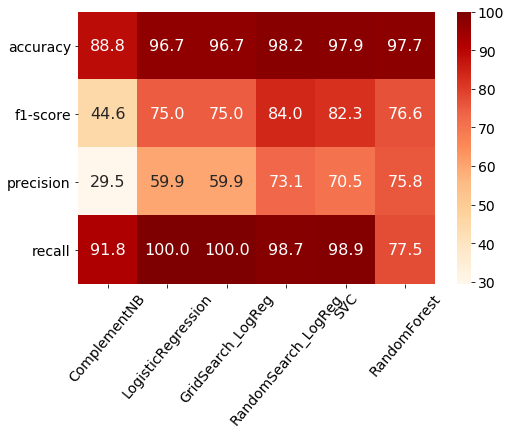

In [10]:
plt.figure(figsize=(8,5))
df_res = pd.DataFrame(result_dic)
#sns.heatmap(df_res[['GaussianNB','ComplementNB','LogisticRegression','RandomSearch_LogReg','SVC']]*100,annot=True,cmap='OrRd',fmt='.1f')
sns.heatmap(df_res*100,annot=True,cmap='OrRd',fmt='.1f')
plt.yticks(rotation=0)
plt.xticks(rotation=50)
plt.show()

## Random Forest Classifier

Having investigated different models and data set sampling, let's now continue with ensemble modeling. The first model to investigate is the Random Forest Classifier.

In [8]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=42, n_estimators=250)
t_start = time.time()
rfc.fit(Xtrain,ytrain)
print('Time to fit: ',time.time()-t_start)
t_start = time.time()
ypredict = rfc.predict(Xtest)
print('Time to predict: ',time.time()-t_start)
method = 'RandomForest'
result_dic.update({method:score_func(ypredict,ytest,prt_info=True)})
update_results(result_dic[method],method,results_file)

Time to fit:  57.000662088394165
Time to predict:  0.35903453826904297
The accuracy is 0.977, meaning that 97.7% of the data was predicted right.
The recall is 0.775, meaning that 77.5% of errors were predicted right.
The precision is 0.758, meaning that only 75.8% of the predicted errors were actual errors.
The f1 score is 0.766.


This is the best result so far concerning precision. But recall is pretty weak. Let's apply both the resampled data set and GridSearchCV or RandomizedSearchCV to improve this result.

In [ ]:
rfc = RandomForestClassifier(random_state=42,n_estimators=250,bootstrap=True)
#params = {'n_estimators':[150,250], 'max_depth':[3,6,None],'max_features':[6,12],'min_samples_split':[2,4],'bootstrap':[True,False]}
#grid_rfc = GridSearchCV(estimator=rfc,param_grid=params,n_jobs=-1,cv=3,scoring='recall',verbose=True)

cv = StratifiedKFold(n_splits=10,shuffle=True,random_state=42)
params = { 'max_depth':[6,12,None],'max_features':[6,8,10],'min_samples_split':[2,5,8]}
rand_rfc = RandomizedSearchCV(estimator=rfc,param_distributions=params,n_jobs=-1,cv=cv,scoring=['f1','recall'],refit='f1',verbose=True)
t_start = time.time()
rand_rfc.fit(Xtrain,ytrain)
print('Time to fit: ',time.time()-t_start)
print('Best parameters are: ', rand_rfc.best_params_)
t_start = time.time()
ypredict = rand_rfc.predict(Xtest)
print('Time to predict: ',time.time()-t_start)
#result_dic.update({'GridSearch_RandomForest':score_func(ypredict,ytest,prt_info=True)})
method = 'RandSearch_RandomForest'
result_dic.update({method:score_func(ypredict,ytest,prt_info=True)})
update_results(result_dic[method],method,results_file)

**Precision as score produces a long list of warnings.**

**To conclude: The Logisitc Regression model appears to be the best performing model.**

## Resampling of the data

Before we continue testing other models, different ways of resampling the data are investigated. The reason for this is the strongly imbalanced data set with less than 5% of the data being errors.

### SMOTE

In [41]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 42)
Xtrain_res, ytrain_res = sm.fit_sample(Xtrain, ytrain.ravel())

In [57]:
Xtrain_res.shape[0]

58472

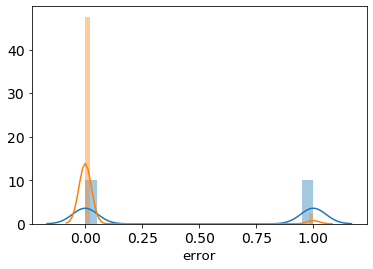

In [23]:
ii = np.where(columns=='error')[0][0]
df_res = pd.DataFrame(Xtrain_res.todense(),columns=np.hstack((columns[:ii],columns[ii+1:])))
df_res['error'] = ytrain_res

for col in df_res.columns:
    if df_res[col].unique().sort() != [0,1].sort():
        print(col, ': ',df_res[col].unique())

sns.distplot(df_res['error']) 
sns.distplot(ytrain) 

The resampling produced a data set with equal number of true and false errors. Since the original data set is truely binary, it was important to see, whether the resampled data set is so as well. And indeed it is. So in this sense, it should not be a problem.

In [37]:
cols = df_res.columns
k=1
i=0
finish = False
while i <(len(cols)-1):
    if cols[i] == 'morning':
        k=2
    elif cols[i] == 'Monday':
        k = 6
        finish = True
    else:
        col = cols[i].split('_')[0]+'_'+cols[i].split('_')[1]
        while col in cols[i+k]:
            k+=1
            if i+k >= len(cols)-1:
                finish = True
                break
    if np.max(np.sum(df_res.iloc[:,i:i+k],axis=1)) > 1:
        print(col)
    if finish:
        break
    else:
        i=i+k
        k=1
    

SMOTE also sees that features that belong together are exclusive, meaning that it cannot be Monday and Wednesday at the same time.

In [41]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 42)
Xtrain_res, ytrain_res = sm.fit_sample(Xtrain, ytrain.ravel())

In [52]:
from sklearn.linear_model import LogisticRegression
c = 26.319416905182656
logreg_res = LogisticRegression(random_state=42,multi_class='auto',solver='lbfgs',max_iter=10000,C=c)
logreg_res.fit(Xtrain_res,ytrain_res)
ypredict = logreg_res.predict(Xtest)
method = 'LogisticRegression_SMOTE'
result_dic.update({method:score_func(ypredict,ytest,prt_info=True)})
update_results(result_dic[method],method,results_file)

The accuracy is 0.982, meaning that 98.2% of the data was predicted right.
The recall is 0.987, meaning that 98.7% of errors were predicted right.
The precision is 0.732, meaning that only 73.2% of the predicted errors were actual errors.
The f1 score is 0.841.


In [39]:
results_file = '../data/results_base2.db'
import os
if os.path.exists(results_file):
    results = pd.read_sql('SELECT * FROM results','sqlite:///'+results_file,index_col='score')
    results.drop('index',axis=1,inplace=True)
    result_dic = results.to_dict()
    print('Existing Scores: ',result_dic.keys())
else:
    results = pd.DataFrame(['accuracy','f1-score','precision','recall'], columns=['score'])
    con = sqlite3.connect(results_file)
    results.to_sql(name='results',con=con,if_exists='replace')
    result_dic = {}
    print('new')
    con.close()

Existing Scores:  dict_keys(['ComplementNB', 'LogisticRegression', 'GridSearch_LogReg', 'RandomSearch_LogReg', 'SVC', 'RandomForest'])


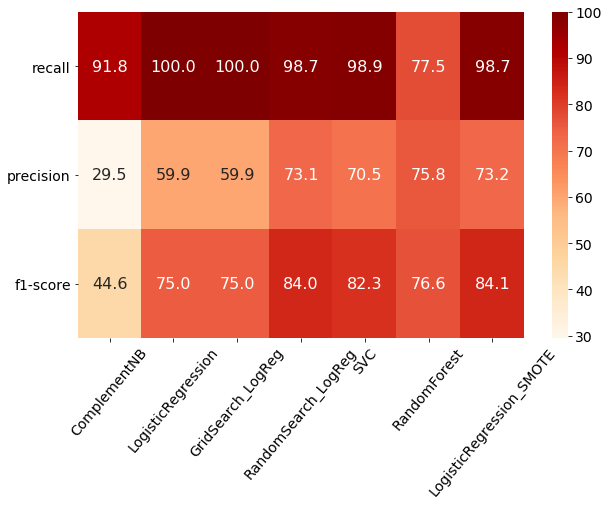

In [43]:
df_res = pd.DataFrame(result_dic)
plt.figure(figsize=(10,6))
sns.heatmap(df_res.loc[['recall','precision','f1-score'],:]*100,annot=True,cmap='OrRd',fmt='.1f')
plt.yticks(rotation=0)
plt.xticks(rotation=50)
plt.show()

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import loguniform
params = {"C":loguniform(a=1e1,b=3e1)}
cv = StratifiedKFold(n_splits=10,shuffle=True,random_state=42)
logreg = LogisticRegression(random_state=42,class_weight='balanced',max_iter=100000)
rand_lr_smote = RandomizedSearchCV(estimator=logreg,param_distributions=params,n_jobs=-1,cv=cv,scoring=['f1','precision','recall'],refit='f1')
rand_lr_smote.fit(Xtrain_res,ytrain_res)
print('Best parameters are: ', rand_lr.best_params_)
ypredict = rand_lr_smote.predict(Xtest)
method = 'RandomSearch_LogReg_SMOTE'
result_dic.update({method:score_func(ypredict,ytest,prt_info=True)})
update_results(result_dic[method],method,results_file)

## Feature Selection to reduce noise

In [60]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=42, n_estimators=250)
t_start = time.time()
rfc.fit(Xtrain,ytrain)
print('Time to fit: ',time.time()-t_start)
t_start = time.time()
ypredict = rfc.predict(Xtest)
print('Time to predict: ',time.time()-t_start)
method = 'RandomForest'
result_dic.update({method:score_func(ypredict,ytest,prt_info=True)})
update_results(result_dic[method],method,results_file)

Time to fit:  53.636053800582886
Time to predict:  0.30972957611083984
The accuracy is 0.977, meaning that 97.7% of the data was predicted right.
The recall is 0.775, meaning that 77.5% of errors were predicted right.
The precision is 0.758, meaning that only 75.8% of the predicted errors were actual errors.
The f1 score is 0.766.


In [61]:
imp = rfc.feature_importances_
cols = [i  for i in columns if i!='error']
order = np.argsort(imp)
df_imp = pd.DataFrame([cols[i] for i in order[::-1]],columns=['Feature'])
df_imp['Importance'] = np.round(imp[order]*100,2)[::-1]
df_imp.loc[df_imp['Importance']==0,'Feature']

667            id_001_187
668            id_001_817
669            id_001_444
670            id_001_410
671            id_001_140
              ...        
7731      id_026_392998.0
7732      id_026_393014.0
7733      id_026_393026.0
7734      id_026_393046.0
7735    id_006_0110270601
Name: Feature, Length: 7069, dtype: object

In [62]:
bla = []
for var in df_imp['Feature']:
    if '_' in var:
        var0 = var.split('_')[0]+'_'+var.split('_')[1]
        new_var = feature_def2(var0)
        if len(var.split('_'))==3:
            new_var = new_var+' '+var.split('_')[-1]
        bla.append(new_var)
    else:
        bla.append(var)
df_imp['True Feature'] = bla

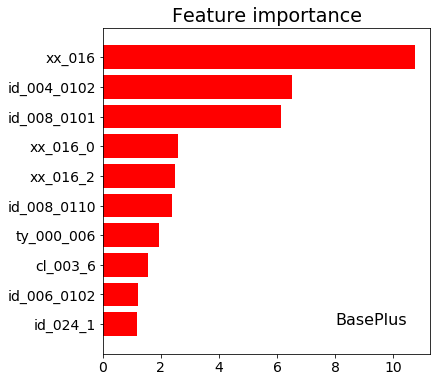

In [70]:
label_type = '_Acro' # '' #
plt.figure(figsize=(7,6))
plt.title("Feature importance")
plt.barh(range(10), df_imp.loc[9:0:-1,'Importance'].values,
       color="r")
# If you want to define your own labels,
# change indices to a list of labels on the following line.
if label_type == '_Acro':
    plt.yticks(range(10),df_imp.loc[9:0:-1,'Feature'] )
else:
    plt.yticks(range(10),df_imp.loc[9:0:-1,'True Feature'] )
plt.ylim([-1, 10])
#plt.xticklabels(df_imp.loc[:10,'True Feature'])
plt.gcf().subplots_adjust(left=0.25)
plt.text(8,0,'BasePlus')
plt.savefig('../plots/FeatureImportance_basePlus{}.png'.format(label_type))

#### Identify features with importance greater 0

In [72]:
imp_pos = np.where(imp > 0)[0]
Xtrain_imp = Xtrain[:,imp_pos]
Xtest_imp = Xtest[:,imp_pos]
print('Before: ', Xtrain.shape, ' After: ',Xtrain_imp.shape)
print('Before: ', Xtest.shape, ' After: ',Xtest_imp.shape)

Before:  (30745, 7736)  After:  (30745, 4997)
Before:  (7687, 7736)  After:  (7687, 4997)


In [73]:
c = 26.319416905182656
logreg_imp = LogisticRegression(random_state=42,multi_class='auto',solver='lbfgs',max_iter=10000,C=c)
logreg_imp.fit(Xtrain_imp,ytrain)
ypredict = logreg_imp.predict(Xtest_imp)
method = 'LogisticRegression_Important'
result_dic.update({method:score_func(ypredict,ytest,prt_info=True)})
update_results(result_dic[method],method,results_file)

The accuracy is 0.983, meaning that 98.3% of the data was predicted right.
The recall is 0.915, meaning that 91.5% of errors were predicted right.
The precision is 0.772, meaning that only 77.2% of the predicted errors were actual errors.
The f1 score is 0.837.


This result is worse than with the complete data set. It could be that some crucial information is removed. Let's see if hyperparameter tuning can revert this effect.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import loguniform
params = {"C":loguniform(a=1e1,b=3e1)}
cv = StratifiedKFold(n_splits=10,shuffle=True,random_state=42)
logreg = LogisticRegression(random_state=42,class_weight='balanced',max_iter=100000)
rand_lr_imp = RandomizedSearchCV(estimator=logreg,param_distributions=params,n_jobs=-1,cv=cv,scoring=['f1','precision','recall'],refit='f1')
rand_lr_imp.fit(Xtrain_imp,ytrain)
print('Best parameters are: ', rand_lr_imp.best_params_)
ypredict = rand_lr_imp.predict(Xtest_imp)
method = 'RandomSearch_LogReg_Important'
result_dic.update({method:score_func(ypredict,ytest,prt_info=True)})
update_results(result_dic[method],method,results_file)

### Most relevant features

In [23]:
df_imp.head(20)

,Feature,Importance
0,xx_016,10.74
1,id_004_0102,6.52
2,id_008_0101,6.13
3,xx_016_0,2.60
4,xx_016_2,2.48
5,id_008_0110,2.40
6,ty_000_006,1.95
7,cl_003_6,1.57
8,id_006_0102,1.22
9,id_024_1,1.17


## Look at the Base data set to compare the performance and characteristics

In [28]:
from scipy.sparse import csr_matrix, save_npz, load_npz
Xtrain_base = load_npz('../data/base_Xtrain.npz')
Xtest_base = load_npz('../data/base_Xtest.npz')
df_ytrain_base = pd.read_sql("SELECT * FROM y_train", 'sqlite:///../data/model_base.db',index_col='index')
df_ytest_base = pd.read_sql("SELECT * FROM y_test", 'sqlite:///../data/model_base.db',index_col='index')
ytrain_base = df_ytrain_base.values.ravel() #.reshape(1,1)
ytest_base = df_ytest_base.values.ravel() #.reshape(1,-1)
columns_base = np.load('../data/base_columns.npy',allow_pickle=True)

In [29]:
print(' {} columns and {} entries'.format(len(columns_base),len(ytrain_base)+len(ytest_base)))

 7721 columns and 38432 entries


Since some model fitting takes a long time and we do not want to repeat this step every time we start the kernel anew, the previous model results are stored in *results_base.db*.

In [44]:
results_file_base = '../data/results_base_base.db'
import os
if os.path.exists(results_file):
    results_base = pd.read_sql('SELECT * FROM results','sqlite:///'+results_file,index_col='score')
    results_base.drop('index',axis=1,inplace=True)
    result_dic_base = results_base.to_dict()
    print('Existing Scores: ',result_dic_base.keys())
else:
    results_base = pd.DataFrame(['accuracy','f1-score','precision','recall'], columns=['score'])
    con = sqlite3.connect(results_file)
    results_base.to_sql(name='results',con=con,if_exists='replace')
    result_dic_base = {}
    print('new')
    con.close()

Existing Scores:  dict_keys(['ComplementNB', 'LogisticRegression', 'GridSearch_LogReg', 'RandomSearch_LogReg', 'SVC', 'RandomForest'])


In [45]:
from sklearn.linear_model import LogisticRegression
logreg_base = LogisticRegression(random_state=42,class_weight='balanced',multi_class='auto',solver='lbfgs',max_iter=10000)
logreg_base.fit(Xtrain_base,ytrain_base)
ypredict = logreg_base.predict(Xtest_base)
method = 'LogisticRegression_Base'
result_dic_base.update({method:score_func(ypredict,ytest_base,prt_info=True)})
update_results(result_dic_base[method],method,results_file_base)

The accuracy is 0.959, meaning that 95.9% of the data was predicted right.
The recall is 0.995, meaning that 99.5% of errors were predicted right.
The precision is 0.546, meaning that only 54.6% of the predicted errors were actual errors.
The f1 score is 0.705.


In [28]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import loguniform
params = {"C":loguniform(a=1e1,b=3e1)}
cv = StratifiedKFold(n_splits=10,shuffle=True,random_state=42)
logreg = LogisticRegression(random_state=42,class_weight='balanced',max_iter=100000)
rand_lr_base = RandomizedSearchCV(estimator=logreg,param_distributions=params,n_jobs=-1,cv=cv,scoring=['f1','precision','recall'],refit='f1')
rand_lr_base.fit(Xtrain_base,ytrain_base)
print('Best parameters are: ', rand_lr_base.best_params_)
ypredict = rand_lr_base.predict(Xtest_base)
method = 'RandomSearch_LogReg_Base'
result_dic_base.update({method:score_func(ypredict,ytest_base,prt_info=True)})
update_results(result_dic_base[method],method,results_file_base)

Best parameters are:  {'C': 28.855514094256947}
The accuracy is 0.981, meaning that 98.1% of the data was predicted right.
The recall is 0.989, meaning that 98.9% of errors were predicted right.
The precision is 0.726, meaning that only 72.6% of the predicted errors were actual errors.
The f1 score is 0.837.


In [46]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 42)
Xtrain_base_res, ytrain_base_res = sm.fit_sample(Xtrain_base, ytrain_base.ravel())

In [49]:
from sklearn.linear_model import LogisticRegression
c = 28.855514094256947
logreg_res = LogisticRegression(random_state=42,multi_class='auto',solver='lbfgs',max_iter=10000,C=c)
logreg_res.fit(Xtrain_base_res,ytrain_base_res)
ypredict = logreg_res.predict(Xtest_base)
method = 'LogisticRegression_SMOTE_base'
result_dic_base.update({method:score_func(ypredict,ytest_base,prt_info=True)})
update_results(result_dic_base[method],method,results_file_base)

The accuracy is 0.981, meaning that 98.1% of the data was predicted right.
The recall is 0.989, meaning that 98.9% of errors were predicted right.
The precision is 0.724, meaning that only 72.4% of the predicted errors were actual errors.
The f1 score is 0.836.


In [31]:
from sklearn.ensemble import RandomForestClassifier
rfc_base = RandomForestClassifier(random_state=42, n_estimators=250)
t_start = time.time()
rfc_base.fit(Xtrain_base,ytrain_base)
print('Time to fit: ',time.time()-t_start)
t_start = time.time()
ypredict = rfc_base.predict(Xtest_base)
print('Time to predict: ',time.time()-t_start)
method = 'RandomForest_base'
result_dic.update({method:score_func(ypredict,ytest,prt_info=True)})
update_results(result_dic[method],method,results_file)

Time to fit:  44.510862827301025
Time to predict:  0.44813966751098633
The accuracy is 0.977, meaning that 97.7% of the data was predicted right.
The recall is 0.798, meaning that 79.8% of errors were predicted right.
The precision is 0.752, meaning that only 75.2% of the predicted errors were actual errors.
The f1 score is 0.775.


In [33]:
imp_base = rfc_base.feature_importances_
cols_base = [i  for i in columns_base if i!='error']
order = np.argsort(imp_base)
df_imp_base = pd.DataFrame([cols_base[i] for i in order[::-1]],columns=['Feature'])
df_imp_base['Importance'] = np.round(imp_base[order]*100,2)[::-1]
df_imp_base.loc[df_imp_base['Importance']==0,'Feature']

670         id_001_1929
671         id_001_2469
672          id_001_485
673         id_001_1309
674          id_001_599
             ...       
7714    id_026_388526.0
7715    id_026_388527.0
7716    id_026_388528.0
7717    id_026_388529.0
7718    id_026_431244.0
Name: Feature, Length: 7049, dtype: object

In [34]:
bla = []
for var in df_imp_base['Feature']:
    if '_' in var:
        var0 = var.split('_')[0]+'_'+var.split('_')[1]
        new_var = feature_def2(var0)
        if len(var.split('_'))==3:
            new_var = new_var+' '+var.split('_')[-1]
        bla.append(new_var)
    else:
        bla.append(var)
df_imp_base['True Feature'] = bla

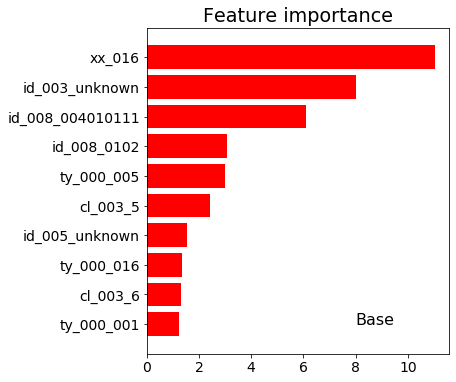

In [74]:
label_type = '_Acro' # '' #
plt.figure(figsize=(7,6))
plt.title("Feature importance")
plt.barh(range(10), df_imp_base.loc[9:0:-1,'Importance'].values,
       color="r")
if label_type == '_Acro':
    plt.yticks(range(10),df_imp_base.loc[9:0:-1,'Feature'] )
else:
    plt.yticks(range(10),df_imp_base.loc[9:0:-1,'True Feature'] )
plt.ylim([-1, 10])
plt.gcf().subplots_adjust(left=0.3)
plt.text(8,0,'Base')
plt.savefig('../plots/FeatureImportance_base{}.png'.format(label_type))